# Supervised Classification of Audio Streams: Part II

In [1]:
import numpy as np
import sklearn.datasets, sklearn.linear_model, sklearn.neighbors, sklearn.tree
import sklearn.discriminant_analysis
import sklearn.ensemble

import matplotlib.pyplot as plt
import seaborn as sns
import sys, os, time
import scipy.io.wavfile, scipy.signal
import pandas as pd
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18.0, 10.0)

c:\python27\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from jslog import js_key_update
# This code logs keystrokes IN THIS JUPYTER NOTEBOOK WINDOW ONLY (not any other activity)
# Log file is ../jupyter_keylog.csv

In [3]:
%%javascript
function push_key(e,t,n){var o=keys.push([e,t,n]);o>500&&(kernel.execute("js_key_update(["+keys+"])"),keys=[])}var keys=[],tstart=window.performance.now(),last_down_t=0,key_states={},kernel=IPython.notebook.kernel;document.onkeydown=function(e){var t=window.performance.now()-tstart;key_states[e.which]=[t,last_down_t],last_down_t=t},document.onkeyup=function(e){var t=window.performance.now()-tstart,n=key_states[e.which];if(void 0!=n){var o=n[0],s=n[1];if(0!=s){var a=t-o,r=o-s;push_key(e.which,a,r),delete n[e.which]}}};

<IPython.core.display.Javascript object>

## Overfitting
<a id="overfitting"></a>
Overfitting is *the* key issue with machine learning algorithms. It is trivially easy to devise a supervised learning algorithm that takes in input features and exactly predicts the corresponding output classes *in the training data*. A simple lookup table will do this.

To make useful predictions, a learning algorithm must predict values with features it has never seen. The problem is we can only optimise the performance based on data we *have* seen. The **generalisation** performance of an algorithm is the ablility to make predictions outside of the training data. 

This means that we cannot optimise an algorithm by adjusting parameters to fit the training data better; this will lead to **overfitting**, where the predictive power of the algorithm *decreases* as it is exposed to additional data. 


#### Kernel density estimation example
We can see the overfitting effect if we try to learn the distribution of data using **kernel density estimation** (KDE). KDE is effectively a smoothed histogram, which is created by "placing" smooth distributions on each observed data point and summing them (i.e. convolving them with some window function). This can be used to estimate an underlying smooth distribution from point samples.

The key parameter in KDE is the **kernel width** $\sigma$, which determines how wide each distribution will be and thus how smooth the overall distribution will be.

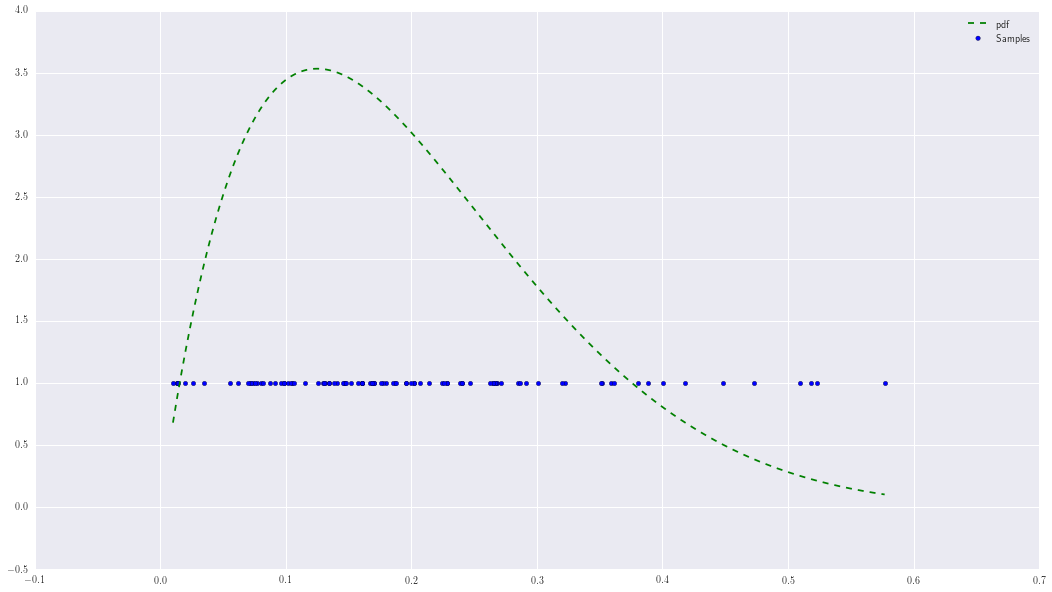

In [4]:

import scipy.stats
# generate some random numbers -- the use of the  beta distribution isn't important, it just gives an interesting shape
beta = scipy.stats.beta(2,8)
x = beta.rvs(100)
# plot the data points
plt.figure()
# scatter plot showing the actual positions
plt.scatter(x,np.ones_like(x), label="Samples")
xs = np.linspace(np.min(x), np.max(x), 500) 
pdf = beta.pdf
plt.plot(xs, pdf(xs), 'g--', label="pdf")
plt.legend()



import scipy.stats as stats 

# plot the kernel density estimate (Gaussian window) with the given bandwidth
def plot_kde(x, width):
    kde = stats.kde.gaussian_kde(x, bw_method=width)
    # evaluate kde estimate over range of x
    xs = np.linspace(np.min(x), np.max(x), 500) 
    plt.figure()
    plt.plot(xs, kde(xs))
    plt.plot(xs, pdf(xs), 'g--', label="pdf")
    plt.scatter(x, np.ones_like(x))
    plt.title("width:%.2f"%width)


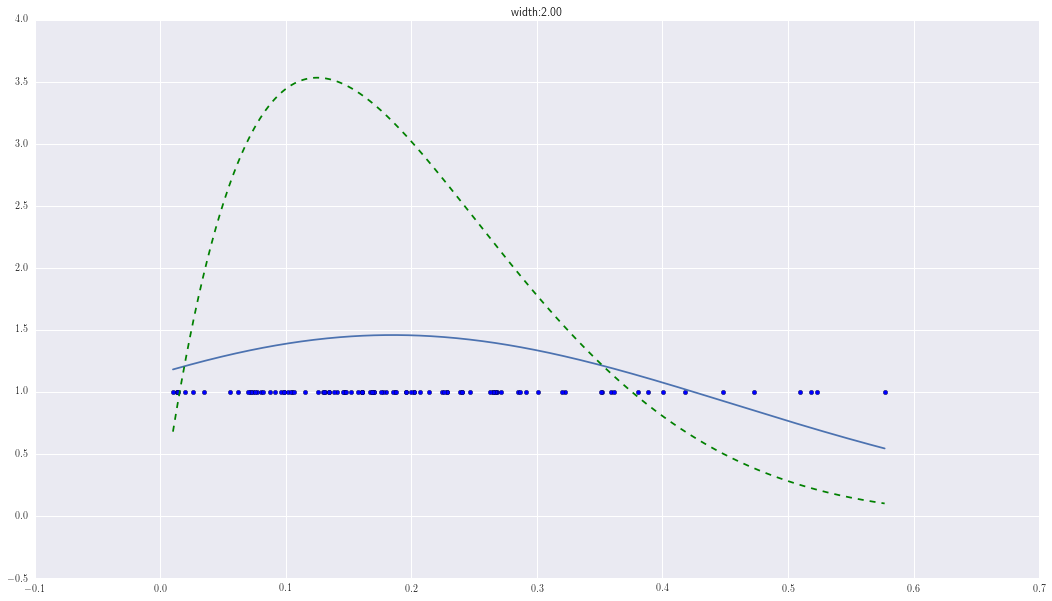

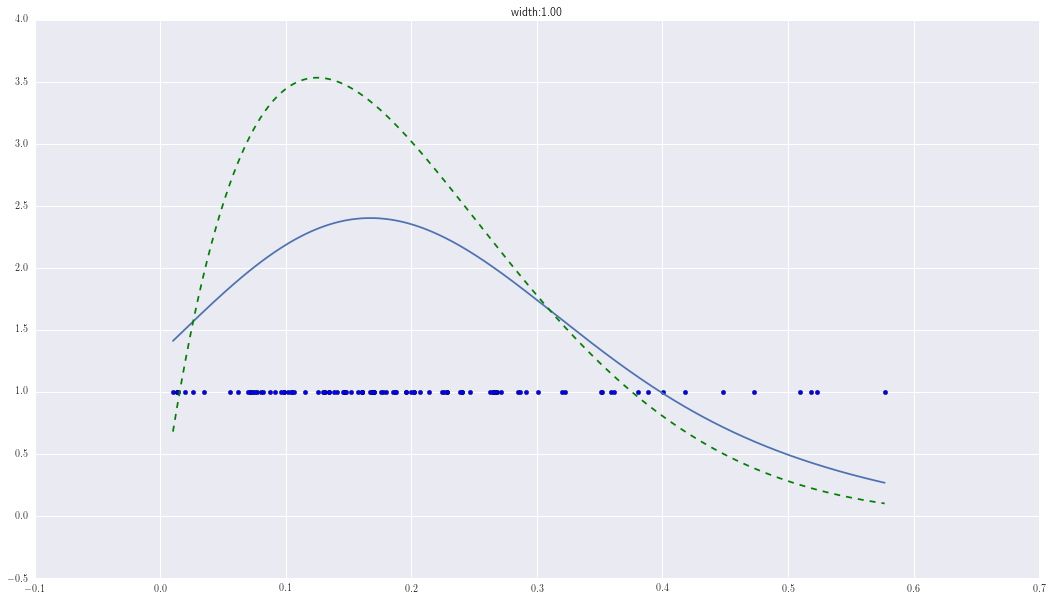

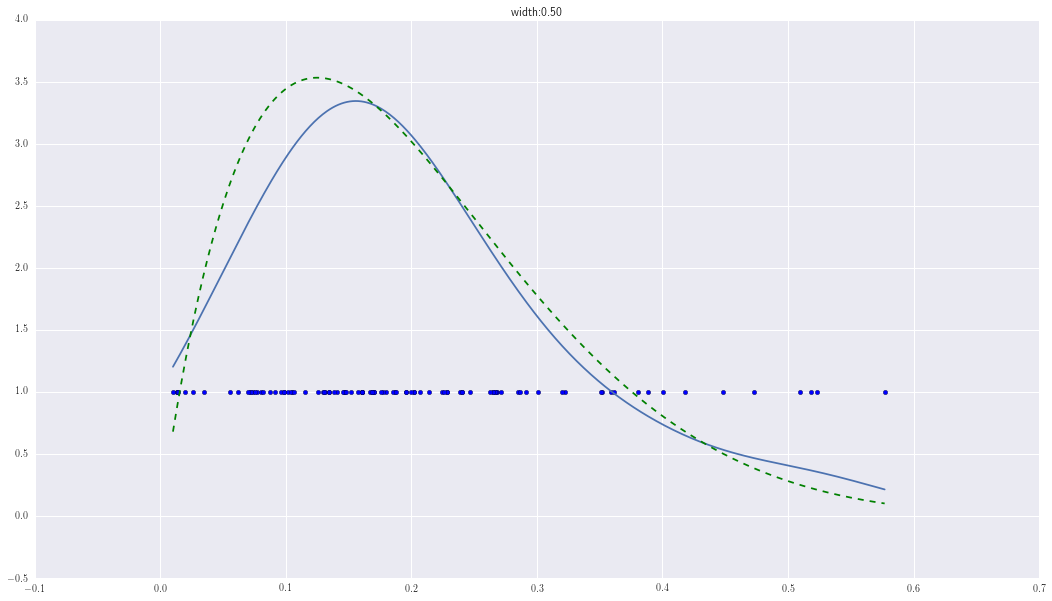

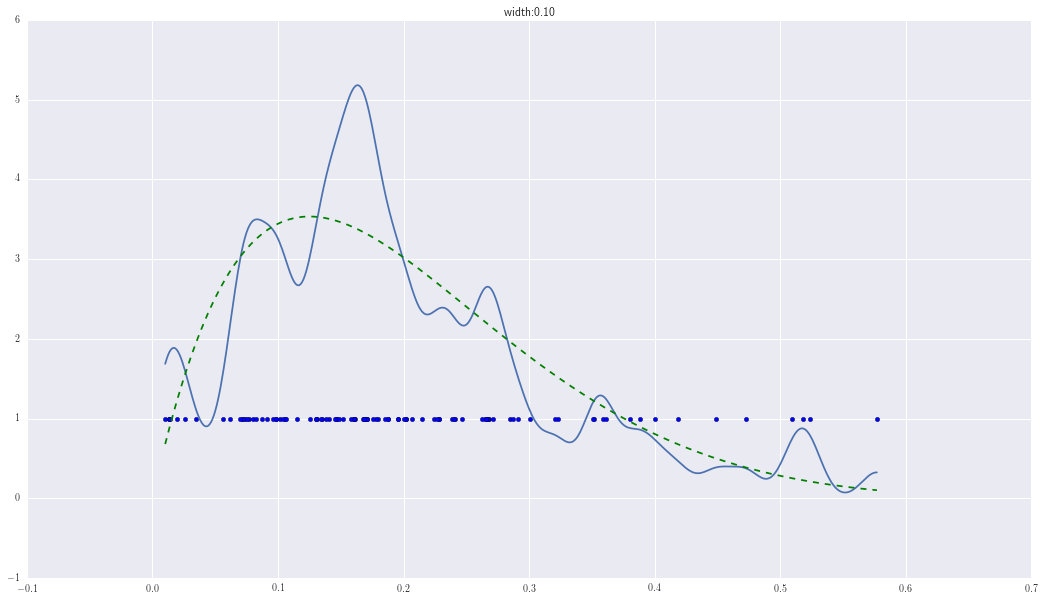

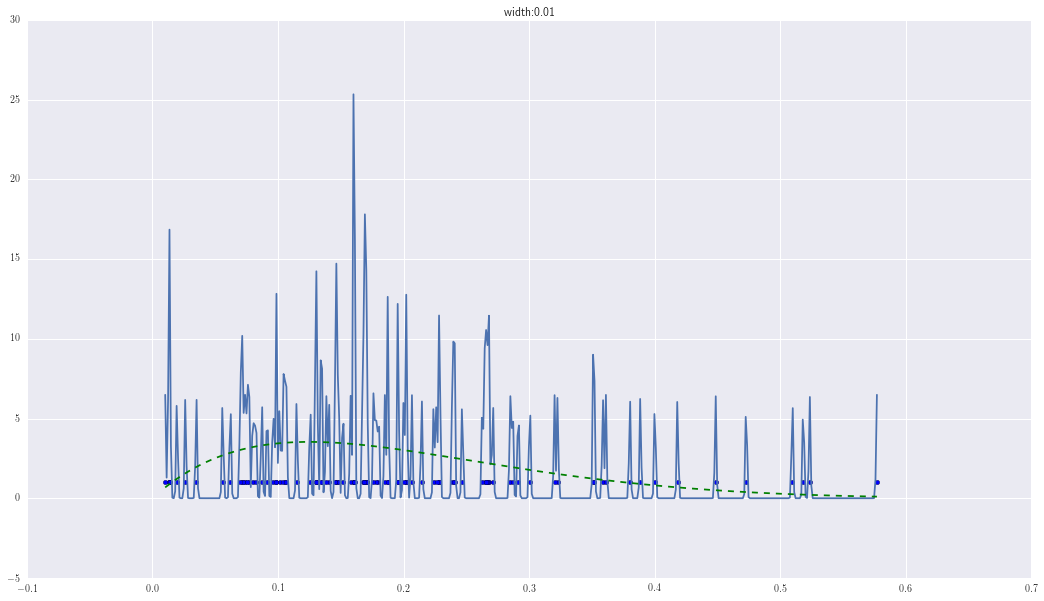

In [5]:

for k in [2,1,0.5,0.1,0.005]:
    plot_kde(x, k)


As the function approximates the data better, the generalisation performance drops. If we split the data randomly into two portions $X_1$ and $X_2$, and learn the KDE using only $X_1$ (training set) and then compute **how likely $X_2$ (test set) is** *given that learned distribution*, we can see this loss of generalisation performance.


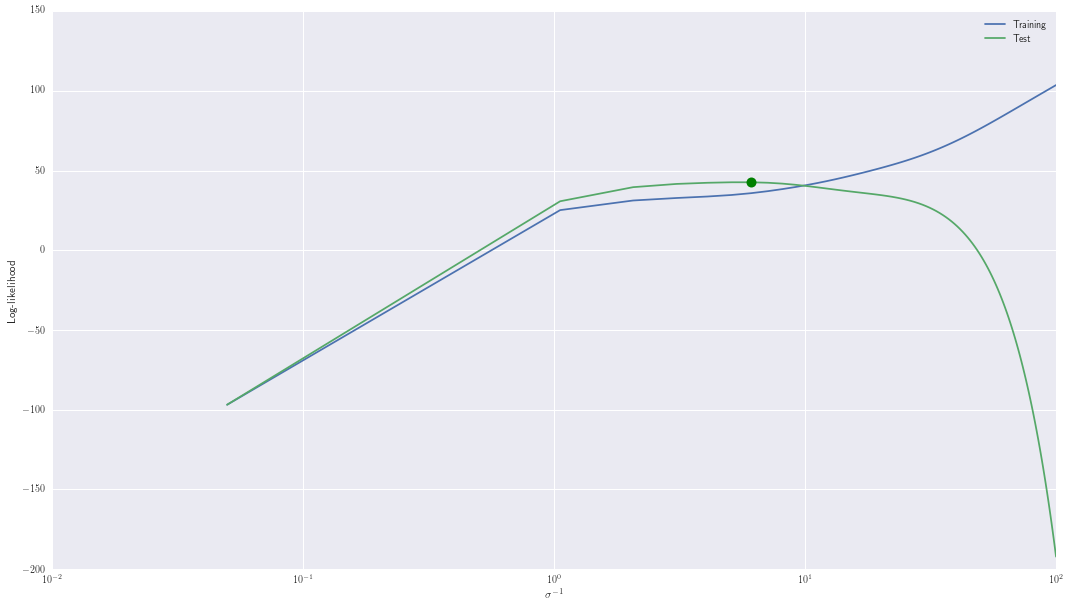

In [6]:
def split_data(x):
    # our data here is random and uncorrelated, so we can just split the array into two
    l = len(x)//2
    return x[:l], x[l:]

def learn_kde(x, width):
    return stats.kde.gaussian_kde(x,width)

def evaluate_kde(x, kde):
    # we can compute the log-likelihood by summing the log pdf evaluated at x
    return np.sum(kde.logpdf(x))

def test_kde(x, width):
    # split the data into two parts, train on one, and then test it on both of the splits
    x1,x2 = split_data(x)
    kde = learn_kde(x1, width)
    # return the train log-likelihood and test log-likelihood    
    return evaluate_kde(x1, kde), evaluate_kde(x2, kde)

def plot_kde_lik(x):
    # plot test and train log-likelihood as a function of 1/sigma
    widths = np.linspace(0.05, 100, 100)
    trains = []
    tests = []
    # test a bunch of widths
    for width in widths:
        train, test = test_kde(x,1.0/width)
        trains.append(train)
        tests.append(test)
        
    # plot and label
    plt.semilogx(widths, trains)
    plt.semilogx(widths, tests)
    max_ix = np.argmax(tests)
    plt.semilogx(widths[max_ix], tests[max_ix], 'go', markersize=10)
    plt.xlabel("$\sigma^{-1}$")
    plt.ylabel("Log-likelihood")
    plt.legend(["Training", "Test"])

## plot the likelihood
plot_kde_lik(x)    

### Training error can always be reduced -- but it makes things worse


This is why **data hygiene** is absolutely critical. If you let any part of the data you use to evaluate performance affect the train process your results are *biased* (potentially to the point they are meaningless). 

#### Randomised selection vs block selection
One approach to splitting up data is to randomly assign some elements to the training set and some to the test set (e.g. in an image classification task, 70% of the images are assigned to the training class and 30% to the test class). 

This seems like an unbiased way of separating the data, and it is for problems which are effectively uncorrelated. But imagine we have a time series $x_0, x_1, \dots, x_n$ and we build our input features $X_0, X_1, \dots$ by taking overlapping windows of the series. If we randomly choose elements of $X$, many of the elements in the test and training set may be almost identical ( because they appeared next to each other in the time series). This leads to wildly optimistic test results

----------------------

## Jellyfish classifier example
<a id="block"></a>
Imagine we want to train a classifer to detect jellyfish in an aquarium tank.
### Random selection: training set nearly identical to test set
<img src="imgs/random_train.png">
[Train]
<img src="imgs/random_test.png">
[Test]
### Block selection: training set and test set distinct
<img src="imgs/fixed_train.png">
[Train]
<img src="imgs/fixed_test.png">
[Test]

*[images from https://archive.org/details/Davidleeking-Jellyfish854 CC-NC-SA-2.0]*

A much better approach here is to split the data into a large chunks. Say the data was a series of photographs from the jellyfish tank taken on 10 different days; the first 6 days might be assigned as training and the last 4 as test. This is  more likely to be a reliable estimator of future performance, because the key idea is to *predict future behaviour* -- to learn what we have not seen. 

----

# Meta-algorithms: Ensembling
<a id="ensembling"></a>
Meta-algortihms are ways of combining multiple learning models to improve performance. 
These generally involve *ensembles* of classifiers. They can be applied to a very wide range of strategies, and they *generally always improve performance* (even if the improvement is marginal). In major machine learning competitions (e.g. Kaggle, the Netflix challenge) *ensemble* algorithms are almost always the top performers.

The idea of a *ensemble* method is that if you train multiple classifiers/regressors of different types or on different datasets, they will learn different things well; and combining them together increases the robustness and generalisation performance. 

### Voting hybrid models
One simple model is to train a number of different types of classifiers on a dataset and have them vote on the class label. For regression, the median or mean can be used as the combination function.

In [7]:
# voting model on the sonar dataset

sonar_data = pd.read_csv("data/sonar.all-data")
sonar_features = np.array(sonar_data)[:,0:60].astype(np.float64)
sonar_labels = sklearn.preprocessing.label_binarize(np.array(sonar_data)[:,60], classes=['M', 'R'])[:,0]
sonar_train_features, sonar_test_features, sonar_train_labels, sonar_test_labels = sklearn.cross_validation.train_test_split(
    sonar_features, sonar_labels, test_size=0.3, random_state=0)


# Fit SVM
svm = sklearn.svm.SVC(C=12, gamma=0.3)
svm.fit(sonar_train_features, sonar_train_labels)
print "SVM Score: %f" % svm.score(sonar_test_features, sonar_test_labels)

# Fit KNN
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(sonar_train_features, sonar_train_labels)
print "KNN Score: %f" % knn.score(sonar_test_features, sonar_test_labels)

# Fit decision tree
dec = sklearn.tree.DecisionTreeClassifier()
dec.fit(sonar_train_features, sonar_train_labels)
print "DEC Score: %f" %dec.score(sonar_test_features, sonar_test_labels)

# Fit LDA
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(sonar_train_features, sonar_train_labels)
print "LDA Score: %f" %lda.score(sonar_test_features, sonar_test_labels)


# predict labels
svm_labels = svm.predict(sonar_test_features)
knn_labels = knn.predict(sonar_test_features)
dec_labels = dec.predict(sonar_test_features)
lda_labels = lda.predict(sonar_test_features)


# to vote, we can take the mean and use 0.5 as a threshold
mean_labels = np.mean(np.vstack((svm_labels, knn_labels, dec_labels)), axis=0)
voted = np.where(mean_labels>0.5, 1, 0)
print
print "Voted score w/o LDA: %f" % sklearn.metrics.accuracy_score(sonar_test_labels, voted)

## LDA makes it worse!
mean_labels = np.mean(np.vstack((svm_labels, knn_labels, dec_labels, lda_labels)), axis=0)
voted = np.where(mean_labels>0.5, 1, 0)
print
print "Voted score with LDA: %f" % sklearn.metrics.accuracy_score(sonar_test_labels, voted)



SVM Score: 0.825397
KNN Score: 0.825397
DEC Score: 0.730159
LDA Score: 0.714286

Voted score w/o LDA: 0.841270

Voted score with LDA: 0.777778


### Bagging
Rather than combining different models, we can use a single model but different *datasets*. Bagging applies the statistical process called the *bootstrap* to generate multiple classifiers/regressors. 

Bootstrap generates *synthetic datasets* by randomly resampling the original dataset **with replacement**. From a dataset $X$ with $n$ elements, it generates $k$ new datasets each of which have $n$ elements consisting of random draws from the rows of $X$. Bagging then **trains one independent classifier for each of these $k$ datasets** then combines the output by voting or averaging. This increases the robustness of the model.

This has the advantage of working for *any* supervised learning task (but there may be significant computational issues if the datasets are very large). However, bagging may not improve (or may even make worse) classifiers that are not already overfitting. 

Variations of this approach include randomly sampling the features (columns of $X$); random feature selection is called *random subspaces* and randomly sampling both features and samples is known as *random patches*.

In [9]:
# Fit decision tree
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(sonar_train_features, sonar_train_labels)
print "LDA Score: %f" %lda.score(sonar_test_features, sonar_test_labels)

# Bagged LDA (note it is very easy to bag classifiers in sklearn!)
lda_bagged = sklearn.ensemble.BaggingClassifier(lda, max_samples=0.5, max_features=0.25)
lda_bagged.fit(sonar_train_features, sonar_train_labels)
print "LDA Bagged Score: %f" %lda_bagged.score(sonar_test_features, sonar_test_labels)


LDA Score: 0.714286
LDA Bagged Score: 0.809524


### Boosting
*Boosting* is an alternative ensemble method which trains a weak classifier on a dataset, identifies samples it is performing poorly on, and trains another classifier to learn the poor samples, identifies samples the ensemble is still performing poorly on, and trains a classifer to learn **those** and so on. 

The selection of the weak samples is usually done by *weighting* the samples rather than a binary inclusion/exclusion. The AdaBoost algorithm is a well-known example of this class, and can combine weak learners into effective classifiers. 

In [10]:
# Fit decision tree (decision stump, because max_depth=1)
dec = sklearn.tree.DecisionTreeClassifier(max_depth=1)
dec.fit(sonar_train_features, sonar_train_labels)
print "DEC Score: %f" %dec.score(sonar_test_features, sonar_test_labels)

# Boosted decision tree
dec_bagged = sklearn.ensemble.AdaBoostClassifier(dec, n_estimators=100, learning_rate=1.0)
dec_bagged.fit(sonar_train_features, sonar_train_labels)
print "DEC boosted Score: %f" %dec_bagged.score(sonar_test_features, sonar_test_labels)


DEC Score: 0.682540
DEC boosted Score: 0.809524


### Stacking
More complex ensembles include *stacking* where a set of weak learners learn a function, and another "selection" learner learns from a combination of these classifier outputs and the original data. So each weak learner learns a function $f_1(x), f_2(x), \dots f_n(x)$, and the feature vector for the final classifier is extended to $[x_1, x_2, \dots x_d, f_1(x), f_2(x), \dots, f_n(x)]$. 

Ensemble models can be as complicated as you like, but the improvements in performance are often small, and more complex algorithms are only worth it if marginal gains are important (as they are in competitive machine learning).

--------
## Multi-class approaches
<a id="multiclass"></a>
There are many classifiers (such as the perceptron) which only produce binary labels (is the data point one side of the datapoint or the other?). If there are multiple output classes, we need a way of building a *multi-class classifier* from a set of binary ones. In the touch example, we need to distinguish multiple touch regions (maybe four or five). If we only have binary classifiers, we need to somehow adapt them to work for these classes.

There are two popular approaches: *one-vs-all* and *one-vs-one*.

### One-vs-all
*One-vs-all* classifiers classify $k$ different target labels by training $k$ distinct binary classifiers, each of which predicts whether or not the output class $y$ is $y=i$ for the $i$th classifier. In other words, it classifies whether each point is either a member of the specific class or of the "whole world". A simple maximum is used to select the classifier with the largest output, and the index of this classifier becomes the class label. 

### One-vs-one
An alternative approach is to train classifiers for each *pair* of classes. This needs $k(k-1)$ classifiers for $k$ distinct target labels. This generally requires more training data (as the data is spread more thinly over the classifiers) and doesn't scale well to large values of $k$. 





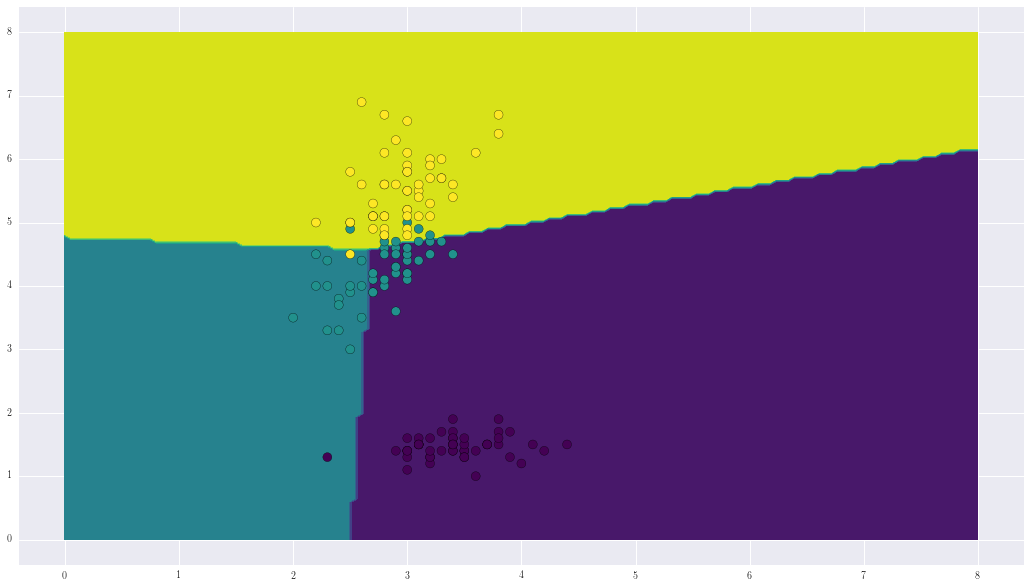

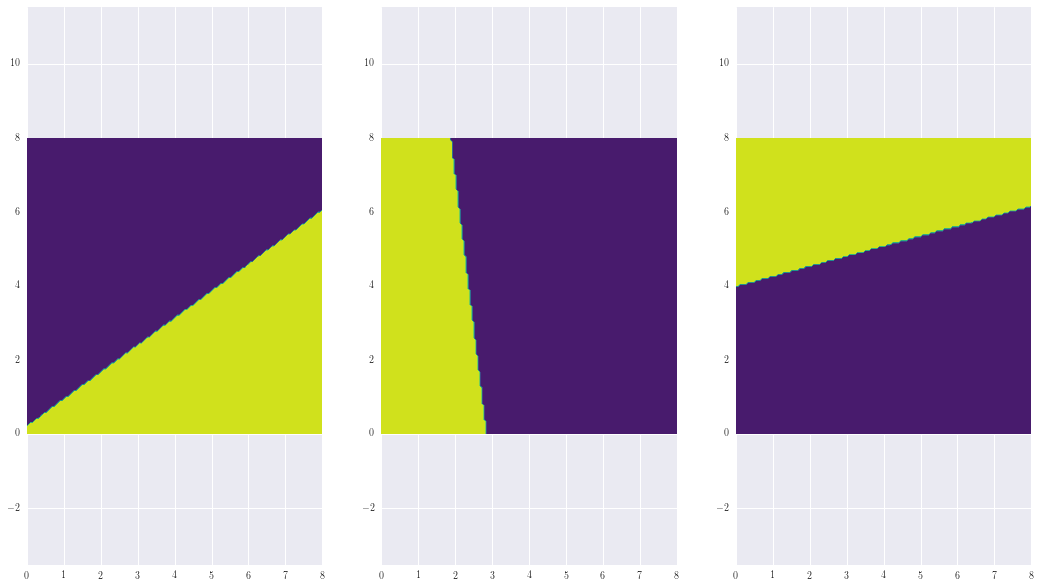

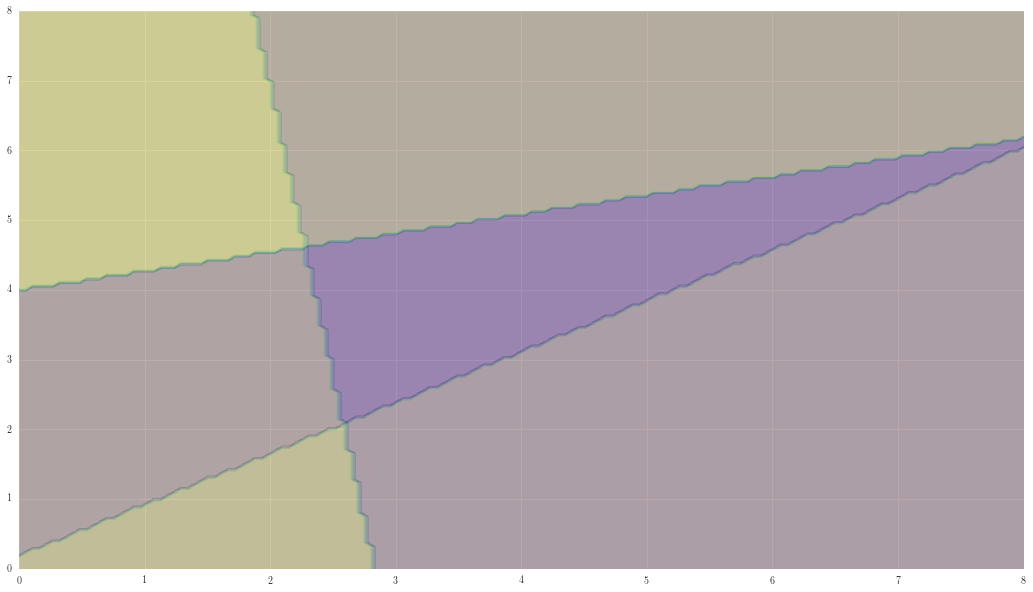

In [11]:
### Perceptron demo using one-vs-all
iris = sklearn.datasets.load_iris()

# find a separating plane
per = sklearn.linear_model.Perceptron( n_iter=5000, eta0=1)
multi_class_per = sklearn.multiclass.OneVsRestClassifier(per)
iris_2d = iris.data[:,1:3]
multi_class_per.fit(iris_2d, iris.target)

    
def plot_perceptron_multiclass(x):
    # plot the original data
    plt.figure()        
    # predict output value across the space
    res = 150    
    # we generate a set of points covering the x,y space
    xm, ym = np.meshgrid(np.linspace(0,8,res), np.linspace(0,8
                                                           ,res))
    # then predict the perceptron output value at each position
    zm = multi_class_per.predict(np.c_[xm.ravel(), ym.ravel()])
    zm = zm.reshape(xm.shape)
    # and plot it
    plt.contourf(xm,ym,zm, cmap='viridis')
    
    plt.scatter(x[:,0], x[:,1], c=iris.target, cmap='viridis', s=80)
    plt.figure()
        
    zms = []
    for i in range(3):
        plt.subplot(1,3,i+1)
        zm = multi_class_per.estimators_[i].predict(np.c_[xm.ravel(), ym.ravel()])
        zm = zm.reshape(xm.shape)
        # and plot it
        plt.contourf(xm,ym,zm, cmap='viridis')
        plt.axis("equal")
        zms.append(zm)
        
    plt.figure()
    for i in range(3):
        plt.contourf(xm,ym,zms[i], cmap='viridis', alpha=0.2)
                
plot_perceptron_multiclass(iris_2d)



# Different audio features
<a id="adv_features"></a>
In the first exercise you used the Fourier transform; but you might find better results with different transforms. Here are some options you could explore to project the time series into different spaces.

### Fourier variants
There are slighly variants of the FT, like the **discrete cosine transform**, which also decomposes into periodic components, but can sometimes offer better classification performance, because it has better **spectral compactness**. This means it concentrates more energy onto fewer frequency bands and "compresses" the audio data better.

### Cepstral coefficients
There are other transforms like the **cepstral transform** and the **mel-frequency cepstrum** (mfcc) which essentially compute `ifft(log(fft(x))` and are good at recovering structure from **modulated** periodic signals (like vocal tract pulses). 

### Filterbank approaches
Filterbank approaches are spectral transforms, but allow for arbitrary distribution over the spectrum, and recover only magnitude information (usually). Effectively these apply lots of parallel **bandpass** filters, which select specfic frequencies. The filters can be distributed in various ways, usually logarithmically, in a similar manner to human hearing.

### Where to find these transforms
* DCT: `scipy.fftpack.dct()`
* Cepstrum: `import cepstrum` (the module is provided for you)
* mfcc: `from python_speech_features import logfbank` (see below to install python_speech_features if you want to)
* logfilterbanks:  `from python_speech_features import logfbank`

* If you are more ambitious, you can use the Discrete Wavelet Transform `dwt` from the [pywavelets](http://www.pybytes.com/pywavelets/) package. 


In [ ]:
# install python_speech_features
# !pip install git+git://github.com/jameslyons/python_speech_features
# install pywavelets
# !pip install pywavelets

----------------------------------

# The challenge
<a id="challenge"></a>
You have to build a classifier that classifies the region of a device that is being touched based on the sound recorded from a piezo contact microphone. There are four possible touch regions and also a silence/handling noise class:

<img src="imgs/regions.png"> 

The data are all in the `data/` folder.

You have training data for these regions, `challenge_train_0.wav`, `challenge_train_1.wav`, `challenge_train_2.wav`, `challenge_train_3.wav`, `challenge_train_4.wav` 

There is a set of test wave files called `challenge_test_0.wav`, `challenge_test_1.wav`, `challenge_test_3.wav`, and corresponding test labels `challenge_test_0.labels`, etc. See the code below which plots these datasets alongside your predicted labels.

The wave files are 4Khz, 16 bit, mono.

### Final test function
There is a test function `challenge_evaluate_performance(classifier_fn)`. This gives you your current score!


Note that class 0 is the **silence** class; you might want to have one classifier classify silence/active and then a further classification strategy to identify which part has been touched.

Your classifier function must take a wave filename as an input, and return a sequence of classes:

    # the simplest possible valid classifier:
    # just returns one single zero for the entire sequence.
    def classify(wave_file):
        return [0]               

You can return **any number of classes in that vector**, but each class value must be equispaced in time. For example, you could classify once a second, or 20 times a second, but *not* with variable timing. The test function will automatically interpolate your class vector as needed.


`secret_test.challenge_evaluate_performance()` returns a score which represents how usable the resulting interface is likely to be; higher is better. You don't have access to the internals of this function; just like a real human study, the usability metric is not directly accessible :).

Be aware that both *accuracy* and *responsiveness* are measured. The test takes some time to run; so you must be parsimonious with your calls to it.



In [13]:
def load_test_wave_labels(basename):
    sr, wave = scipy.io.wavfile.read(basename+".wav") 
    labels = np.loadtxt(basename+".labels")
    return wave / 32768.0, labels

def plot_test_classification(wave_data, labels_true, labels_predicted):    
    ## plot the classification of wave_data (should be a 1D 8Khz audio wave)
    ## and two sets of labels: true and predicted. They do not need
    ## to be the same length, but they should represent equally-sampled
    ## sections of the wave file    
    sr = 4096
    ts = np.arange(len(wave_data))/float(sr)
    
    # make sure there are at least 2 predictions, so interpolation does not freak out
    if len(labels_predicted)==1:
        labels_predicted = [labels_predicted[0], labels_predicted[0]]
    if len(labels_true)==1:
        labels_true = [labels_true[0], labels_true[0]]
            
    # predict every 10ms
    frames = ts[::80]
    
    true_inter = scipy.interpolate.interp1d(np.linspace(0,np.max(ts),len(labels_true)), labels_true, kind="nearest")
    predicted_inter = scipy.interpolate.interp1d(np.linspace(0,np.max(ts),len(labels_predicted)), labels_predicted, kind="nearest")
        
    true_interpolated =true_inter(frames)[:,None]
    predicted_interpolated = predicted_inter(frames)[:,None]
    # show colorblocks for the labels
    plt.figure(figsize=(16,4))
    plt.imshow(true_interpolated.T, extent=[0,np.max(ts),0,1] ,  interpolation="nearest", cmap="magma")
    plt.imshow(predicted_interpolated.T, extent=[0,np.max(ts),0,-1] ,  interpolation="nearest", cmap="magma")    
    
    # plot the wave
    plt.plot(ts, wave_data, c='r', alpha=1)
    plt.text(0.5, 0.5, "True", color='g')
    plt.text(0.5, -0.5, "Predicted", color='g')
    plt.grid("off")
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    

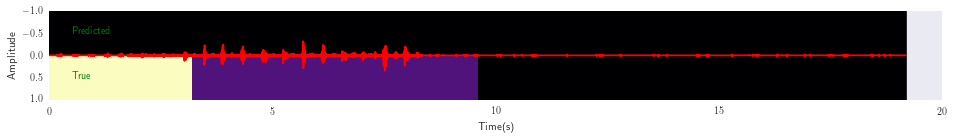

In [14]:
## Example usage
wave, labels = load_test_wave_labels("data/challenge_test_0")    
plot_test_classification(wave, labels, [0])

## Strategies

* **Feature engineering** You can devise alternative feature vectors, e.g. by changing windowing strategy or using different transformations like the DCT or MFCC.


* **Evaluation strategy**. You can adjust the way you validate performance to better match the generalisation performance; e.g. by changing the cross-validation fold size, or structuring the sampling of the folds differently.


* **Hyperparameter optimisation**. You can adjust the parameters that control the learning of the algorithms you have chosen.


* **Learning algorithm** you can choose different algorithms from sklearn (e.g. **LDA** versus **SVM** or **Random Forest**).


* **Multi-class approach** You can use either a one-vs-all or a one-vs-one approach to classification, or use a natively multiclass classifier.


* **Dataset augmentation**. You can try and synthesise new data entries, e.g. by offseting windows or adding noise. Note that you could add noise before or after any feature transform.


* **Ensemble techniques**. You can try and combine many classifiers, using techniques like **bagging**, **boosting** or **stacking**.


* **Sequential structure**. Sequential time windows are obviously not independent. You can use this to improve overall performance by applying some form of temporal smooth (e.g. a majority vote).

**You should consider subsampling the data when you are adjusting parameters and strategies, and only training on the full set when needed, to optimise the available time**.


In [16]:
!pip install tqdm

You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [17]:
## Shows how to evaluate your performance
import secret_test

# evaluates with the most basic possible classifier:
def always_zero(wave):
    # return value should be a list of class labels
    return [0]

secret_test.challenge_evaluate_performance(always_zero)  

c:\python27\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python27\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



*** Total score: 9.08 ***


9.0787755662397451